# Loading Data

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV,Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

train_data_df = pd.read_csv(r'D:\\datasets\Housingprice\train.csv')
test_data_df = pd.read_csv(r'D:\\datasets\Housingprice\test.csv')

data = pd.concat((train_data_df.loc[:,'MSSubClass':'SaleCondition'],
                      test_data_df.loc[:,'MSSubClass':'SaleCondition']))

data.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal


# Making Skewed data normal

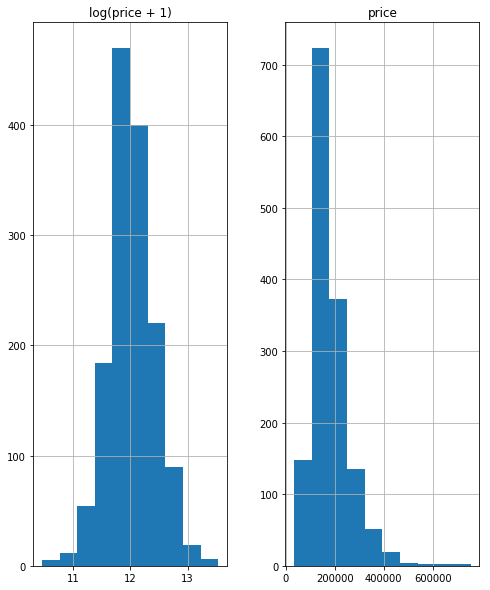

In [112]:
#plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train_data_df["SalePrice"] , "log(price + 1)":np.log1p(train_data_df["SalePrice"])})
prices.hist()
plt.show()

In [113]:
#log transform the target:
train_data_df["SalePrice"] = np.log1p(train_data_df["SalePrice"])
print(train_data_df["SalePrice"].head(5))

#log transform skewed numeric features:
numeric_feats = data.dtypes[data.dtypes != "object"].index
print(numeric_feats)

skewed_feats = train_data_df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
print(skewed_feats)

skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
print(skewed_feats)

data[skewed_feats] = np.log1p(data[skewed_feats])

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
OverallQual       0.216721
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF      

# Creating dummy variables for categorical features

In [114]:
data = pd.get_dummies(data)
print(data.head(5))

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    4.110874     4.189655  9.042040            7            5       2003   
1    3.044522     4.394449  9.169623            6            8       1976   
2    4.110874     4.234107  9.328212            7            5       2001   
3    4.262680     4.110874  9.164401            7            5       1915   
4    4.110874     4.442651  9.565284            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2          ...            \
0          2003    5.283204    6.561031         0.0          ...             
1          1976    0.000000    6.886532         0.0          ...             
2          2002    5.093750    6.188264         0.0          ...             
3          1970    0.000000    5.379897         0.0          ...             
4          2000    5.860786    6.486161         0.0          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0     

# Replacing NAN with Mean of column data

In [115]:
#filling NA's with the mean of the column:
data =data.fillna(data.mean())

# Model

In [116]:
#creating matrices for sklearn:
X_train = data[:train_data_df.shape[0]]
X_test = data[train_data_df.shape[0]:]
y = train_data_df.SalePrice


def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# Simple Linear Model

In [125]:
from sklearn.linear_model import LinearRegression
    
regr=LinearRegression()
regr.fit(X_train,y)
regr.coef_
regr.intercept_
y_pred=regr.predict(X_test)
print("LINEAR MODEL RMSE:",rmse_cv(regr).mean())

LINEAR MODEL RMSE: 0.16524087909050586


# Ridge Regression

In [118]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
print(cv_ridge)

[0.13893637694024755, 0.137775382771879, 0.13501433618086026, 0.13136184989399566, 0.1286489244611187, 0.12782179689257314, 0.1273373466867076, 0.12752940439753813, 0.12895888148450055, 0.13099437857191396, 0.13316366423370266]


Text(0,0.5,'rmse')

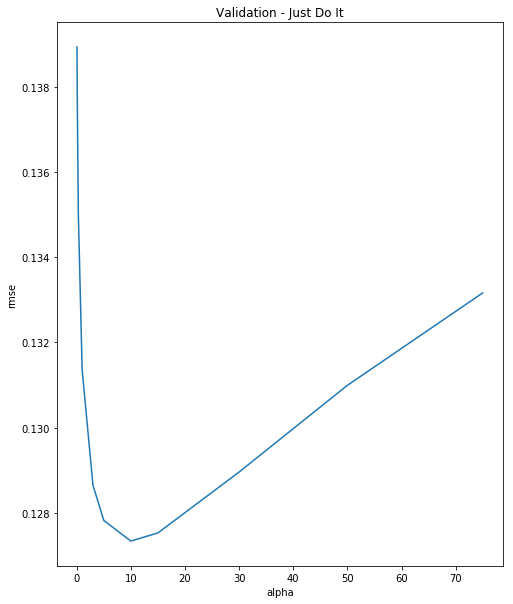

In [119]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")


In [124]:
print("RIDGE RMSE:",cv_ridge.min())

RIDGE RMSE: 0.1273373466867076


# Lasso Regression

In [123]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("LASSO RMSE:",rmse_cv(model_lasso).mean())

LASSO RMSE: 0.12314421090977443


# Identifying Important Features

In [77]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [79]:
#print(coef)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [95]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

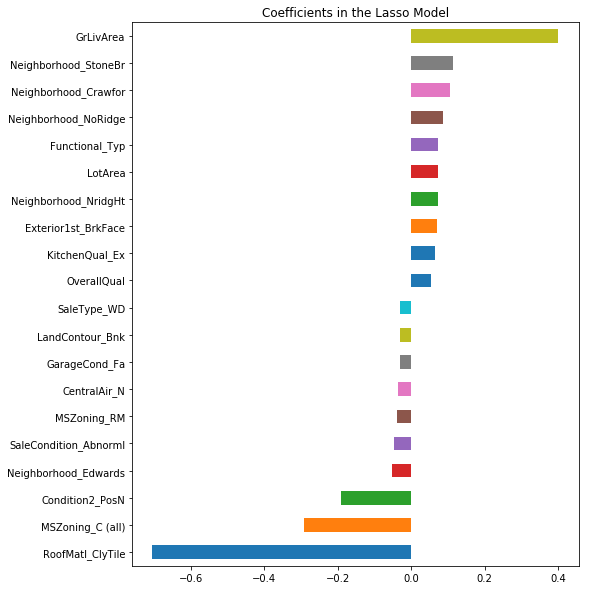

In [97]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

SUMMARY:

    LINEAR MODEL RMSE: 0.16524087909050586
    
    RIDGE RMSE: 0.1273373466867076
    
    LASSO RMSE: 0.12314421090977443
    
        Lasso Regreesion perfoms better than othe models with least error